# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="assets\pic1.png"/>

Then you will want to run the above command:

<img src="assets\pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Project Overview
The Starbucks Project is one of the Udacity Data Science Nanodegree's Capstone Challenges.




### Problem Statement

### 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2. Load Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 3. Data Exploration

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print('How many NaN value in portfolio dataset? {}'\
      .format(portfolio.isna().sum().sum()))

How many NaN value in portfolio dataset? 0


In [5]:
portfolio.index

RangeIndex(start=0, stop=10, step=1)

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
portfolio.channels.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

In [8]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

Explored the 'object' type of columns, There are some relationships between 'channels' and offer_type. 


In [9]:
def clean_portfolio(df=portfolio):
    '''
    INPUT: 
        df(DataFrame): portfolio dataset
    OUTPUT:
        new_df(DataFrame): cleaned data 
    '''
    channels_dummies = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
    offer_type_dummies = pd.get_dummies(portfolio['offer_type'])
    new_df = pd.concat([df, channels_dummies, offer_type_dummies], axis=1).drop(['channels','offer_type'], axis=1)
    new_df = new_df.rename(columns = {'id': 'offer_id'})
    columns_order = ["offer_id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    return new_df[columns_order]

new_portfolio = clean_portfolio()
new_portfolio

,offer_id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
print('How many NaN value in profile dataset? {}'.format(profile.isna().sum().sum()))
profile.isnull().sum()

How many NaN value in profile dataset? 4350


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
profile[(profile['gender'].isnull())&(profile['income'].isnull())]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


The 'gender' column is None , the 'age' is 118 and the 'icome' is NaN. So I think I need to check the percentage of NaN values. If the percentage is not high, I can delete the data.

In [13]:
print('There are {:.2f} % NaN value in profile'\
      .format(((profile[(profile['gender'].isnull())&(profile['income'].isnull())].shape[0]/profile.shape[0])*100)))


There are 12.79 % NaN value in profile


In [14]:
def clean_profile(df=profile):
    '''
    INPUT: 
        df(DataFrame): profile dataset
    OUTPUT:
        new_df(DataFrame): cleaned data 
    '''
    df = df.copy()
    df = df.dropna()
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format = '%Y%m%d')
    df['member_days'] = (datetime.datetime.today().date() - df['became_member_on'].dt.date).dt.days
    df = df.drop(['became_member_on'], axis=1)
    
    gender_dummies = pd.get_dummies(df['gender'])
    df = pd.concat([df, gender_dummies], axis=1).drop(['gender'], axis=1)
   
    df = df.rename(columns = {'id': 'customer_id', 'F': 'female', 'M': 'male', 'O': 'gender_o'})
    columns_order = ['customer_id', 'female', 'male','gender_o','age', 'income', 'member_days']

    return df[columns_order]

In [15]:
new_profile = clean_profile()
new_profile.head()

,customer_id,female,male,gender_o,age,income,member_days
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,55,112000.0,1171
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,75,100000.0,1238
5,e2127556f4f64592b11af22de27a7932,0,1,0,68,70000.0,886
8,389bc3fa690240e798340f5a15918d5c,0,1,0,65,53000.0,962
12,2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,58,51000.0,1052


/Users/tom/opt/anaconda3/envs/deep-learning/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


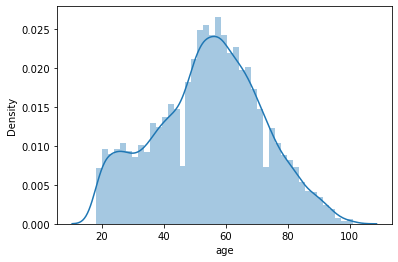

In [16]:
sns.distplot(a=new_profile['age'], kde=True);

/Users/tom/opt/anaconda3/envs/deep-learning/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


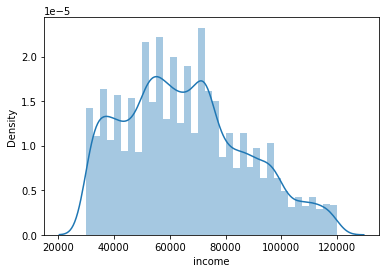

In [17]:
sns.distplot(a=new_profile['income'], kde=True);

/Users/tom/opt/anaconda3/envs/deep-learning/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


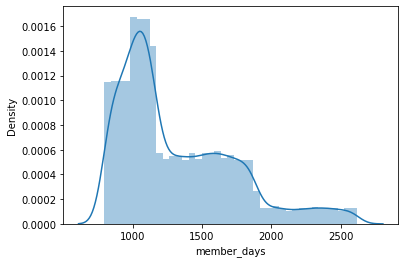

In [18]:
sns.distplot(a=new_profile['member_days'], kde=True);

Ages 30 to 70 are our main target customers

In [19]:
new_profile.describe()

,female,male,gender_o,age,income,member_days
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.413423,0.572277,0.014300,54.393524,65404.991568,1317.478988
std,0.492464,0.494765,0.118729,17.383705,21598.299410,419.205158
min,0.000000,0.000000,0.000000,18.000000,30000.000000,795.000000
25%,0.000000,0.000000,0.000000,42.000000,49000.000000,1003.000000
50%,0.000000,1.000000,0.000000,55.000000,64000.000000,1153.000000
75%,1.000000,1.000000,0.000000,66.000000,80000.000000,1592.000000
max,1.000000,1.000000,1.000000,101.000000,120000.000000,2618.000000


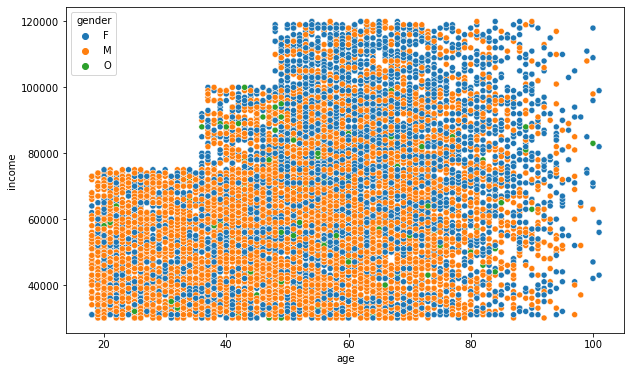

In [20]:
plt.figure(figsize=(10,6))

x =  new_profile['age']
y =  new_profile['income']
hue = profile['gender']
sns.scatterplot(x=x, y=y, hue=hue);

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [21]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [24]:
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [25]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

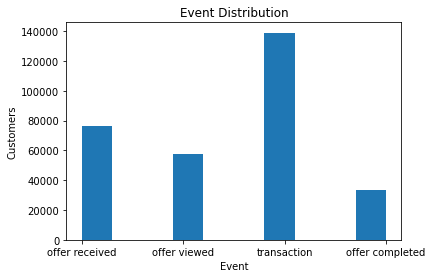

In [26]:
plt.hist(transcript['event'], bins = 10);
plt.xlabel('Event');
plt.ylabel('Customers');
plt.title('Event Distribution');

In [27]:
transcript.value

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [28]:
transcript[transcript.event=='transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [29]:
transcript[transcript.event=='transaction'].head(10).value

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
12678                  {'amount': 33.9}
12686                  {'amount': 0.22}
12687                 {'amount': 18.59}
12691                 {'amount': 18.01}
12696                 {'amount': 19.11}
Name: value, dtype: object

In [30]:
transcript[transcript.event=='offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [31]:
transcript[transcript.event=='offer received'].head(10).value

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
Name: value, dtype: object

In [32]:
transcript[transcript.event=='offer viewed'].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [33]:
transcript[transcript.event=='offer viewed'].head(10).value

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12656    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12660    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12661    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
12662    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12663    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
Name: value, dtype: object

In [34]:
transcript[transcript.event=='offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [35]:
transcript[transcript.event=='offer completed'].head(10).value

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12717    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
12721    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
12744    {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
12764    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12767    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
Name: value, dtype: object

In [36]:
def clean_transcript(df = transcript):
    '''
    INPUT: 
        df(DataFrame): transcript dataset
    OUTPUT:
        new_df(DataFrame): cleaned data 
    '''
    
    df = df.copy()
    event_dummies = pd.get_dummies(df['event'])
    new_df = pd.concat([df, event_dummies], axis=1).drop(['event'], axis=1)
    
    new_df['offer_id'] = df.value.\
    apply(lambda x: list(x.values())[0] if list(x.keys())[0] in ['offer id', 'offer_id'] else 0)
    
    new_df['amount'] = df.value.apply(lambda x: x.get('amount', 0))

    new_df['reward'] = df.value.apply(lambda x: x.get('reward', 0))

    new_df['time'] = round(df.time/24)
    
    new_df.drop(['value'], axis=1, inplace=True)
    
    new_df = new_df.rename(columns = {'person': 'customer_id','offer received':'offer_received',\
                                      'offer viewed':'offer_viewed','offer completed':'offer_completed'})
    
    columns_order = ['customer_id','offer_id','time',\
                     'offer_received', 'offer_viewed','offer_completed','reward',\
                     'transaction','amount']
    
    return new_df[columns_order]

In [37]:
new_transcript = clean_transcript()
new_transcript

,customer_id,offer_id,time,offer_received,offer_viewed,offer_completed,reward,transaction,amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,0,0,0,0,0.00
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1,0,0,0,0,0.00
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,1,0,0,0,0,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0.0,1,0,0,0,0,0.00
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1,0,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,0,30.0,0,0,0,0,1,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,0,30.0,0,0,0,0,1,9.53
306531,a00058cf10334a308c68e7631c529907,0,30.0,0,0,0,0,1,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,0,30.0,0,0,0,0,1,3.53


In [38]:
# check the new table 
transcript.iloc[12658].value

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [39]:
new_transcript.iloc[12658]

customer_id        9fa9ae8f57894cc9a3b8a9bbe0fc1b2f
offer_id           2906b810c7d4411798c6938adc9daaa5
time                                              0
offer_received                                    0
offer_viewed                                      0
offer_completed                                   1
reward                                            2
transaction                                       0
amount                                            0
Name: 12658, dtype: object

In [40]:
# check the time transform by row's index
transcript.iloc[306530].time

714

In [41]:
new_transcript.iloc[306530].time

30.0

In [42]:
new_transcript

,customer_id,offer_id,time,offer_received,offer_viewed,offer_completed,reward,transaction,amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,1,0,0,0,0,0.00
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,1,0,0,0,0,0.00
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,1,0,0,0,0,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0.0,1,0,0,0,0,0.00
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,1,0,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,0,30.0,0,0,0,0,1,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,0,30.0,0,0,0,0,1,9.53
306531,a00058cf10334a308c68e7631c529907,0,30.0,0,0,0,0,1,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,0,30.0,0,0,0,0,1,3.53


In [43]:
new_profile

,customer_id,female,male,gender_o,age,income,member_days
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,55,112000.0,1171
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,75,100000.0,1238
5,e2127556f4f64592b11af22de27a7932,0,1,0,68,70000.0,886
8,389bc3fa690240e798340f5a15918d5c,0,1,0,65,53000.0,962
12,2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,58,51000.0,1052
...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,1,0,0,45,54000.0,847
16996,2cb4f97358b841b9a9773a7aa05a9d77,0,1,0,61,72000.0,808
16997,01d26f638c274aa0b965d24cefe3183f,0,1,0,49,73000.0,1341
16998,9dc1421481194dcd9400aec7c9ae6366,1,0,0,83,50000.0,1666


In [44]:
new_portfolio

,offer_id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


### 4. Prepare the Data

我们的目标客户是关注我们推荐的，也就是查看 offer viewed 对于我们来说就是有意的发送，无论是否在这期间购买。所以我们要排除从不观看优惠的

In [45]:
def prepare_data(df_portfolio, df_profile, df_transcript):
    
    filter_by_transcript = df_transcript.groupby(['customer_id']).sum().sort_values(by= ['offer_viewed','amount','reward'], ascending=False)
    filter_by_transcript = filter_by_transcript[~(filter_by_transcript.offer_viewed == 0)]
    filter_by_transcript = filter_by_transcript[~(filter_by_transcript.offer_completed == 0)].reset_index()

    offer_df = df_transcript.merge(df_portfolio, how="inner", left_on="offer_id", right_on="offer_id")
    offer_df = offer_df.groupby(['customer_id']).sum().sort_values(by= ['offer_viewed','amount'], ascending=False)
    offer_df = offer_df.loc[:,['difficulty','duration','email','mobile','social','web','bogo','discount','informational']]

    df_data = filter_by_transcript.merge(new_profile, how="inner", left_on="customer_id", right_on="customer_id")
    df_data = df_data.merge(offer_df, how="inner", left_on="customer_id", right_on="customer_id").drop(['time','duration'], axis=1)
    columns_order = ['customer_id', 'member_days','female', 'male', 'gender_o', 'age', 'income',\
                     'offer_received', 'offer_viewed', 'offer_completed',\
                     'email', 'mobile', 'social','web',\
                     'bogo', 'discount', 'informational','difficulty',\
                     'reward', 'transaction', 'amount']
    return df_data[columns_order]

In [46]:
starbucks_data = prepare_data(new_portfolio, new_profile, new_transcript)
starbucks_data.to_csv('data/starbucks_data.csv', index = False)

In [47]:
starbucks_data

,customer_id,member_days,female,male,gender_o,age,income,offer_received,offer_viewed,offer_completed,...,mobile,social,web,bogo,discount,informational,difficulty,reward,transaction,amount
0,d240308de0ee4cf8bb6072816268582b,1186,1,0,0,43,94000.0,6,6,5,...,14,9,14,6,9,2,156,25,14,1251.99
1,7d7f271652d244f78b97c73cd734c553,1649,0,1,0,37,98000.0,6,6,4,...,13,11,10,8,6,2,151,28,14,1106.17
2,e0570660882b49db860b43f704e5590b,1160,1,0,0,38,72000.0,6,6,4,...,16,13,9,6,6,4,105,19,15,987.54
3,9ae56116908640fc83477982da0aaec4,1689,0,1,0,21,39000.0,6,6,5,...,17,15,14,9,6,2,117,31,26,953.39
4,41486bbaab7a49e2afc05d2b48d3b00f,1865,0,1,0,44,75000.0,6,6,4,...,16,7,12,6,6,4,90,14,13,874.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11911,a996a6df1fa94375a43faab4524ec7ae,1153,0,1,0,50,42000.0,3,1,1,...,4,4,5,2,3,0,44,3,4,9.44
11912,d2f79806cdbc4b68aea25148dcd8d551,1110,0,1,0,36,36000.0,4,1,1,...,6,3,6,3,3,0,45,5,4,9.35
11913,6671bb69613249e595e42e0594444789,1096,1,0,0,47,39000.0,4,1,1,...,5,3,6,1,4,1,46,3,2,9.06
11914,8e62dbff5dac441391ee3a5564270085,929,0,1,0,51,42000.0,4,1,1,...,6,3,6,4,1,1,30,5,3,7.39


In [48]:
starbucks_data.describe()

,member_days,female,male,gender_o,age,income,offer_received,offer_viewed,offer_completed,email,mobile,social,web,bogo,discount,informational,difficulty,reward,transaction,amount
count,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000,11916.000000
mean,1367.010322,0.448640,0.536338,0.015022,55.224236,67800.939913,4.545065,3.518966,2.713578,10.777610,9.884945,7.090131,8.805556,4.641323,4.643421,1.492867,86.074354,13.428919,9.246559,139.962030
std,417.144724,0.497376,0.498699,0.121645,17.035316,21728.662494,1.040062,1.230222,1.300810,2.852694,2.982946,3.179102,3.105671,2.965192,2.925482,1.541111,34.434868,8.499062,5.118959,133.506299
min,795.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,2.000000,1.000000,5.280000
25%,1038.000000,0.000000,0.000000,0.000000,44.000000,52000.000000,4.000000,3.000000,2.000000,9.000000,8.000000,5.000000,7.000000,3.000000,3.000000,0.000000,60.000000,7.000000,5.000000,57.577500
50%,1264.000000,0.000000,1.000000,0.000000,56.000000,67000.000000,5.000000,4.000000,3.000000,11.000000,10.000000,7.000000,9.000000,5.000000,5.000000,1.000000,81.000000,12.000000,8.000000,112.795000
75%,1642.250000,1.000000,1.000000,0.000000,67.000000,83000.000000,5.000000,4.000000,4.000000,13.000000,12.000000,9.000000,11.000000,6.000000,6.000000,2.000000,107.000000,19.000000,12.000000,179.847500
max,2618.000000,1.000000,1.000000,1.000000,101.000000,120000.000000,6.000000,6.000000,6.000000,18.000000,18.000000,18.000000,18.000000,18.000000,17.000000,10.000000,255.000000,55.000000,36.000000,1608.690000


### 5. Machine Learning Model

In [49]:
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from xgboost import XGBClassifier, plot_importance

pd.options.mode.chained_assignment = None  

In [50]:
df_model = pd.read_csv('data/starbucks_data.csv')

In [51]:
df_model.drop(['customer_id'], axis=1, inplace=True)
df_model

,member_days,female,male,gender_o,age,income,offer_received,offer_viewed,offer_completed,email,mobile,social,web,bogo,discount,informational,difficulty,reward,transaction,amount
0,1186,1,0,0,43,94000.0,6,6,5,17,14,9,14,6,9,2,156,25,14,1251.99
1,1649,0,1,0,37,98000.0,6,6,4,16,13,11,10,8,6,2,151,28,14,1106.17
2,1160,1,0,0,38,72000.0,6,6,4,16,16,13,9,6,6,4,105,19,15,987.54
3,1689,0,1,0,21,39000.0,6,6,5,17,17,15,14,9,6,2,117,31,26,953.39
4,1865,0,1,0,44,75000.0,6,6,4,16,16,7,12,6,6,4,90,14,13,874.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11911,1153,0,1,0,50,42000.0,3,1,1,5,4,4,5,2,3,0,44,3,4,9.44
11912,1110,0,1,0,36,36000.0,4,1,1,6,6,3,6,3,3,0,45,5,4,9.35
11913,1096,1,0,0,47,39000.0,4,1,1,6,5,3,6,1,4,1,46,3,2,9.06
11914,929,0,1,0,51,42000.0,4,1,1,6,6,3,6,4,1,1,30,5,3,7.39


In [52]:
# Data normalization
column_normalize = ['member_days', 'female', 'male', 'gender_o', 'age', 'income',
       'offer_received', 'offer_viewed', 'offer_completed', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational', 'difficulty',
       'reward', 'transaction', 'amount']

for col in column_normalize:
    df_model[col] = minmax_scale(df_model[col])
    
df_model.columns = df_model.columns.astype(str)
df_model.to_csv('data/normalize_starbucks_data.csv', index = False)

In [53]:
df_model.head()

,member_days,female,male,gender_o,age,income,offer_received,offer_viewed,offer_completed,email,mobile,social,web,bogo,discount,informational,difficulty,reward,transaction,amount
0,0.214482,1.0,0.0,0.0,0.301205,0.711111,1.0,1.0,0.8,0.933333,0.777778,0.500000,0.777778,0.333333,0.529412,0.2,0.595918,0.433962,0.371429,0.777537
1,0.468459,0.0,1.0,0.0,0.228916,0.755556,1.0,1.0,0.6,0.866667,0.722222,0.611111,0.555556,0.444444,0.352941,0.2,0.575510,0.490566,0.371429,0.686593
2,0.200219,1.0,0.0,0.0,0.240964,0.466667,1.0,1.0,0.6,0.866667,0.888889,0.722222,0.500000,0.333333,0.352941,0.4,0.387755,0.320755,0.400000,0.612607
3,0.490400,0.0,1.0,0.0,0.036145,0.100000,1.0,1.0,0.8,0.933333,0.944444,0.833333,0.777778,0.500000,0.352941,0.2,0.436735,0.547170,0.714286,0.591309
4,0.586945,0.0,1.0,0.0,0.313253,0.500000,1.0,1.0,0.6,0.866667,0.888889,0.388889,0.666667,0.333333,0.352941,0.4,0.326531,0.226415,0.342857,0.542188


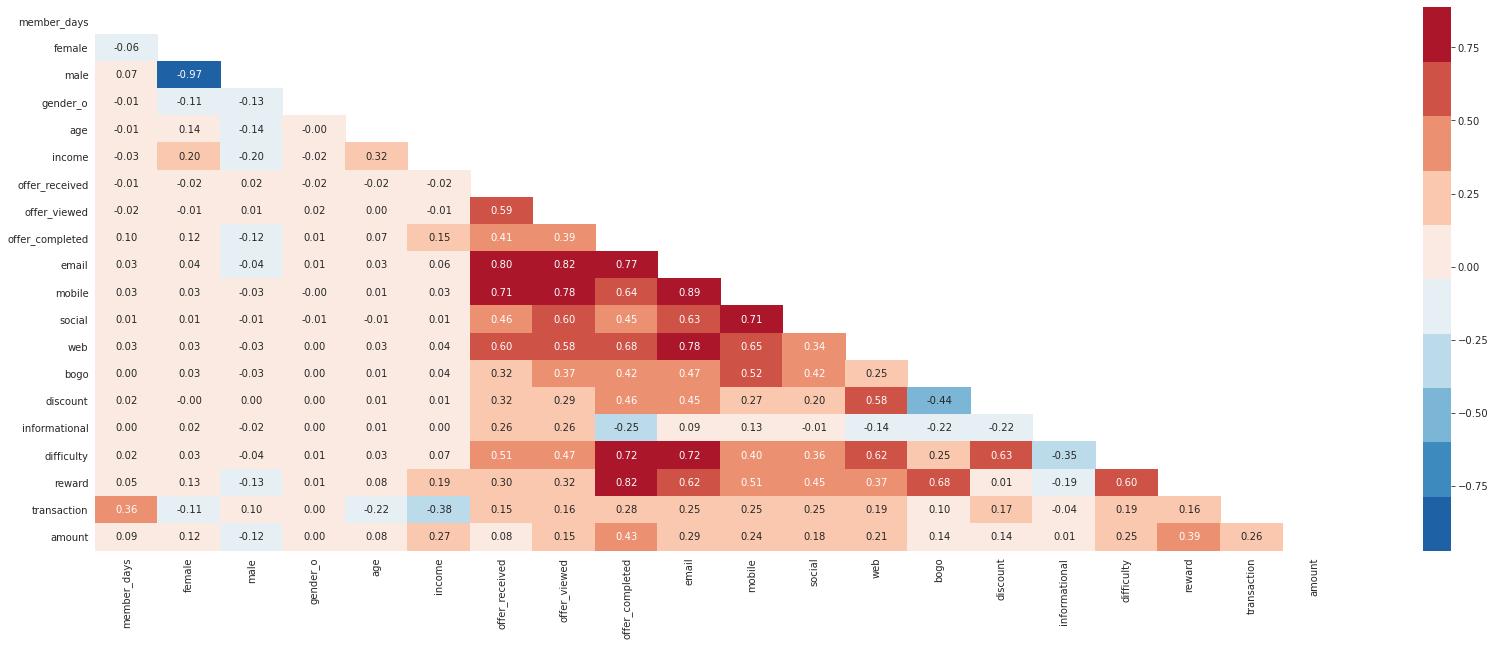

In [54]:
df_model = shuffle(df_model)
corr = df_model.corr()
mask = np.triu(corr)
cmap = sns.color_palette("RdBu_r", 10)
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize = (28, 10))
    ax = sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, fmt = '.2f')

In [55]:
df_model['response'] = np.where((df_model['offer_completed'] > 0.5), 1, 0)
df_model.drop(['offer_completed'], axis=1, inplace=True)

In [56]:
features = df_model.drop('response', axis=1)
target = df_model['response']

In [57]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=45)


In [58]:
eval_set = [(X_train, Y_train), (X_valid, Y_valid)]

In [59]:
model = XGBClassifier(learning_rate=0.1, objective = 'binary:logistic')
model.fit(X_train, Y_train, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=30, verbose=False)
Y_pred = model.predict(X_valid , ntree_limit=model.best_ntree_limit)

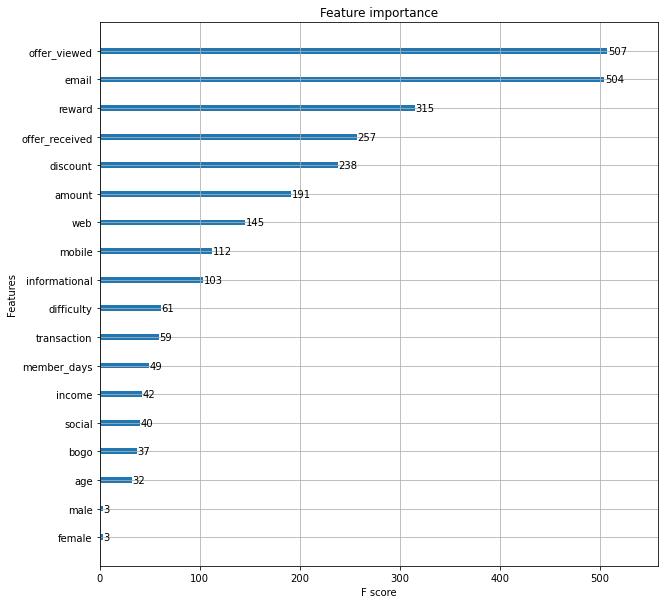

In [60]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_importance(model, ax=ax);

In [61]:
X_train.columns

Index(['member_days', 'female', 'male', 'gender_o', 'age', 'income',
       'offer_received', 'offer_viewed', 'email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'informational', 'difficulty', 'reward',
       'transaction', 'amount'],
      dtype='object')

In [62]:
X_train = X_train[['member_days', 'female', 'male', 'gender_o', 'age', 'income','email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'reward']]

clf = MLPClassifier(solver='adam', activation='logistic',alpha=1e-4,hidden_layer_sizes=(64,64,64), \
                    random_state=45,max_iter=10000,verbose=10,tol=0.000000000001)

clf.fit(X_train, Y_train)

Iteration 1, loss = 0.59918044
Iteration 2, loss = 0.59653396
Iteration 3, loss = 0.59134932
Iteration 4, loss = 0.55733345
Iteration 5, loss = 0.40977088
Iteration 6, loss = 0.26787218
Iteration 7, loss = 0.22449688
Iteration 8, loss = 0.20124032
Iteration 9, loss = 0.18537660
Iteration 10, loss = 0.17316525
Iteration 11, loss = 0.16170352
Iteration 12, loss = 0.15259226
Iteration 13, loss = 0.14548170
Iteration 14, loss = 0.13865413
Iteration 15, loss = 0.13319375
Iteration 16, loss = 0.12943099
Iteration 17, loss = 0.12760026
Iteration 18, loss = 0.12633951
Iteration 19, loss = 0.12314016
Iteration 20, loss = 0.12253714
Iteration 21, loss = 0.11920461
Iteration 22, loss = 0.12059666
Iteration 23, loss = 0.11887440
Iteration 24, loss = 0.11777178
Iteration 25, loss = 0.11913043
Iteration 26, loss = 0.11669078
Iteration 27, loss = 0.11642199
Iteration 28, loss = 0.11760958
Iteration 29, loss = 0.11787087
Iteration 30, loss = 0.11534937
Iteration 31, loss = 0.11558371
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=(64, 64, 64),
              max_iter=10000, random_state=45, tol=1e-12, verbose=10)

In [63]:
X_valid = X_valid[['member_days', 'female', 'male', 'gender_o', 'age', 'income','email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'reward']]
Y_pred = clf.predict(X_valid)

In [64]:
accuracy_score(Y_valid, Y_pred)

0.9609899328859061

In [65]:
cm = confusion_matrix(Y_valid, Y_pred)
cm

array([[1687,   53],
       [  40,  604]])

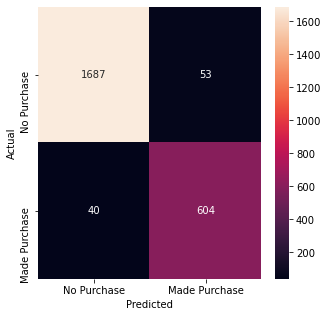

In [66]:
fig, ax= plt.subplots(figsize=(5,5))

confusion_matrix = pd.crosstab(Y_valid, Y_pred, rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g', ax = ax)
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [ ]:
df_model = pd.read_csv('data/starbucks_data.csv')
df_model.drop(['customer_id'], axis=1, inplace=True)

In [ ]:
features = df_model[['member_days', 'female', 'male', 'gender_o', 'age', 'income','email', 'mobile', 'social', 'web', 'bogo', 'discount', 'reward']]
target = df_model['amount']

X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=45)

train_dataset = TensorDataset(torch.tensor(X_train.values.tolist()), torch.tensor(Y_train.values.tolist()))
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = TensorDataset(torch.tensor(X_valid.values.tolist()), torch.tensor(Y_valid.values.tolist()))
validloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)


In [ ]:
class Network(nn.Module):
    def __init__(self, input_size=13, layer1_size=64, layer2_size=64, output_size=1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, output_size)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        
        return x

model = Network()
model

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for x, y in trainloader:
        
        optimizer.zero_grad()
        
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for x, y in validloader:
                y_hat = model(x)
                test_loss = criterion(y_hat, y)
                
                
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(validloader))
        accuracy = torch.mean(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)),
              "Test Accuracy: {:.3f}".format(accuracy))

In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)